# TensorFlow Data Loading & Classification - COVID-19


**Deep Learning and Its Applications to Signal and Image Processing and Analysis, 361-2-1120**

**Shaked Cohen - shaked0@post.bgu.ac.il**

In the following assignment we will create a dataset and costum model for classification of pneumonia cases.

**We will deal with imbalnced data, train a classification CNN model for 3 class classification (Normal,Bacterial, Covid-19), expirament with Test Time Augmentation and Transfer Learning**

The assignment will hopefully give you the tools needed to address real world datasets and help you with your own research challanges.




# Import Libraries

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import resample

# mount common drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shareddrives/DNN_Ofek_Elad_Tomer/A2'
logs = '/content/drive/Shareddrives/DNN_Ofek_Elad_Tomer/A2/logs'
if not os.path.exists(logs):
    os.makedirs(logs)
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/DNN_Ofek_Elad_Tomer/A2
/content/drive/Shareddrives/DNN_Ofek_Elad_Tomer/A2


# 1. Load and Explore the Data


## Load the Data

In order to address this classification problem we first need to create our dataset. In this section you will load the data from 2 different datasets and combine them into data for training and testing

### Load COVID-19 chest X-Ray

Clone COVID-19 X-Ray dataset repository

https://github.com/ieee8023/covid-chestxray-dataset

The data consists of X-ray images of pneumonia cases gathered from different sources.

Please refer to the link to read about the given data.
Additional info can be found in the dataset paper :
https://arxiv.org/abs/2003.11597


In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


Set images and metadata files path and examine data

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

covid_images_path = Path("covid-chestxray-dataset/images")
covid_metadata_path = Path("covid-chestxray-dataset/metadata.csv")

We use pandas to convert the metadata CSV to a dataframe object.

If you are unfamiliar with pandas please refer to:

https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

covid_metadata = pd.read_csv(covid_metadata_path)

A look at the metadata:

You can read the paper for description of the data contents.

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

covid_metadata.head(10)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN
5,4,5.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 30, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1b.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive diffuse interstitial opacities and...,NaN,NaN
6,5,NaN,NaN,NaN,Pneumonia,NaN,NaN,Y,Y,Y,...,2017,NaN,images,ARDSSevere.png,NaN,https://en.wikipedia.org/wiki/File:ARDSSevere.png,CC BY-SA,Severe ARDS. Person is intubated with an OG in...,NaN,NaN
7,6,0.0,NaN,NaN,Pneumonia/Viral/COVID-19,Y,NaN,Y,Y,Y,...,"January 6, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2a.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
8,6,4.0,NaN,NaN,Pneumonia/Viral/COVID-19,Y,NaN,Y,Y,Y,...,"January 10, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2b.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
9,3,4.0,M,74.0,Pneumonia/Viral/SARS,NaN,N,NaN,NaN,NaN,...,2004,"Mount Sinai Hospital, Toronto, Ontario, Canada",images,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,10.1148/rg.242035193,https://pubs.rsna.org/doi/10.1148/rg.242035193,NaN,SARS in a 74-year-old man who developed sympto...,NaN,NaN


In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

#List the images
list(covid_images_path.glob("*"))[0:10]

[PosixPath('covid-chestxray-dataset/images/000001-1.jpg'),
 PosixPath('covid-chestxray-dataset/images/000001-1.png'),
 PosixPath('covid-chestxray-dataset/images/000001-10.jpg'),
 PosixPath('covid-chestxray-dataset/images/000001-11.jpg'),
 PosixPath('covid-chestxray-dataset/images/000001-12.jpg'),
 PosixPath('covid-chestxray-dataset/images/000001-13.jpg'),
 PosixPath('covid-chestxray-dataset/images/000001-14.jpg'),
 PosixPath('covid-chestxray-dataset/images/000001-15.jpg'),
 PosixPath('covid-chestxray-dataset/images/000001-17.jpg'),
 PosixPath('covid-chestxray-dataset/images/000001-18.jpg')]

Visualize some cases

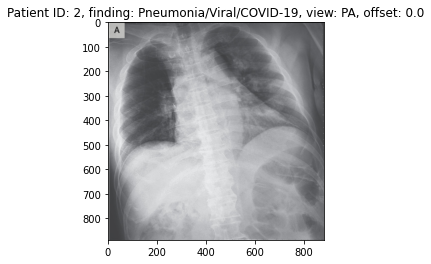

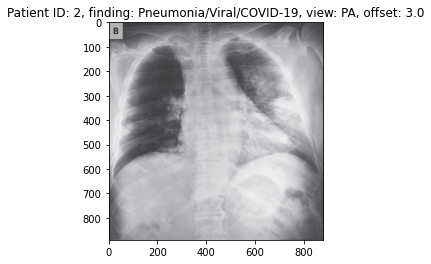

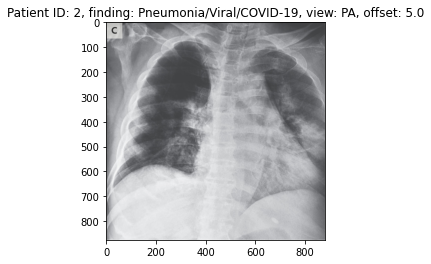

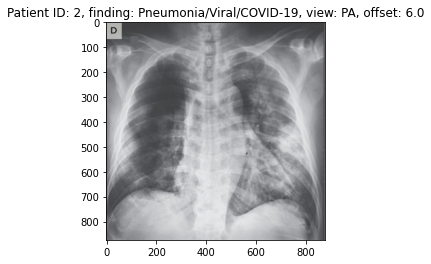

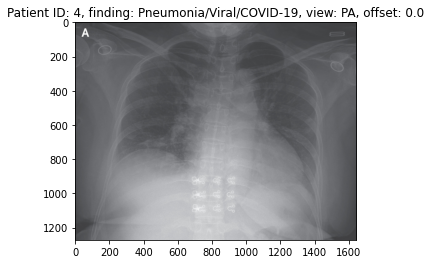

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

for index, case in covid_metadata.head(5).iterrows():
  image_path = covid_images_path / case["filename"]
  plt.figure()
  plt.title("Patient ID: {0}, finding: {1}, view: {2}, offset: {3}".format(case["patientid"],case["finding"],case["view"],case["offset"]))
  plt.imshow(plt.imread(image_path),cmap='gray')
plt.show()

#### Filter Covid-19 Dataset
Write your own code to filter the metadata dataframe to contain only posteroanterior - "PA" (back-to-front) views.

Return a dataframe that contains finding/full filepath as in the following figure:
<table>
  <tr>
    <th></th>
    <th>finding</th>
    <th>filepath</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Pneumonia/Viral/COVID-19</td>
    <td>some/file/path</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Pneumonia/Viral/COVID-19</td>
    <td>another/file/path</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pneumonia/Viral/SARS</td>
    <td>some/other/file/path</td>
  </tr>
    <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

### Fill in your code
pd.options.mode.chained_assignment = None
# filter only PA
covid_metadata_filtered = covid_metadata[covid_metadata['view'] == 'PA']
# create path for each row /7 assign
paths = "covid-chestxray-dataset/images/" + covid_metadata_filtered['filename']
covid_metadata_filtered.loc[:, 'filepath'] = paths
# filter for necessary columns only
covid_metadata_filtered = covid_metadata_filtered[['finding', 'filepath']]
# display to check
covid_metadata_filtered.head()

,finding,filepath
0,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-a-20...
1,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-b-20...
2,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-c-20...
3,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-d-20...
4,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...


Filter your dataframe so it contains only COVID-19 cases:

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

### Fill in your code
covid_metadata_filtered = covid_metadata_filtered[covid_metadata_filtered['finding'] == 'Pneumonia/Viral/COVID-19']
print(len(covid_metadata_filtered))

196


### Load Pneumonia and Normal chest X-Ray

> Indented block



This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).


For more information [chest X-Ray](https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images)

##### Installing the [Kaggle API](https://github.com/Kaggle/kaggle-api) in Colab

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


##### Using the Kaggle API

For a more complete list of what you can do with the API, visit https://github.com/Kaggle/kaggle-api.

##### Downloading Pneumonia and Normal chest X-Ray dataset

In [ ]:
!kaggle datasets download "tolgadincer/labeled-chest-xray-images"

labeled-chest-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip labeled-chest-xray-images.zip

Archive:  labeled-chest-xray-images.zip
replace chest_xray/test/NORMAL/NORMAL-1049278-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

##### Create Train and Test DataFrames
Create Train and Test DataFrames for the NORMAL/BACTERIA catagories using Pandas Dataframe. Be sure it is of the same format of the covid 19 dataframe:
<table>
  <tr>
    <th></th>
    <th>finding</th>
    <th>filepath</th>
  </tr>
  <tr>
    <td>0</td>
    <td>NORMAL</td>
    <td>some/file/path</td>
  </tr>
  <tr>
    <td>1</td>
    <td>BACTERIA</td>
    <td>another/file/path</td>
  </tr>
    <tr>
    <td>2</td>
    <td>NORMAL</td>
    <td>some/other/file/path</td>
  </tr>
    <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

# take chest_xray directories, leace only bacteria and convert to df
def get_metadata(part_dir):

    dfs = []

    # cond = PNEUMONIA or NORMAL
    for cond in os.listdir(part_dir):

        cond_dir = part_dir + '/' + cond

        # choose non virus images
        images_paths = [cond_dir + '/' + img for img in os.listdir(cond_dir) if 'VIRUS' not in img]

        # put them in a df and append to df list
        df = pd.DataFrame(images_paths, columns=['filepath'])
        df['finding'] = cond if cond == 'NORMAL' else 'BACTERIA'
        dfs.append(df)

    concatted = pd.concat(dfs)
    return concatted

cwd = os.getcwd()
train = get_metadata(cwd + '/chest_xray/train')
test = get_metadata(cwd + '/chest_xray/test')

## Create a full dataset





concatenate the dataframes into one 2 dataframes: Test, Train

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

# join chest X-Ray dataset to one
chest_xray = pd.concat([train, test])

# join with previous ds
ds = pd.concat([chest_xray, covid_metadata_filtered])

ds.head(2)
print(set(ds['finding']))

{'Pneumonia/Viral/COVID-19', 'BACTERIA', 'NORMAL'}


For each dataframe convert findings from string to numeric classes, using the following dictionary:



In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

finding_to_label = {
    'NORMAL':0,
    'BACTERIA':1,
    'Pneumonia/Viral/COVID-19':2,
}
label_to_finding = {v: k for k, v in finding_to_label.items()}

### Fill in your code
ds.replace({"finding": finding_to_label}, inplace=True)
print(set(ds['finding']))

{0, 1, 2}


#### Train Test Split
after looking at the second dataset as well, we notice that our data is imbalanced - very small amount of covid samples, a lot of PNEUMONIA\BACTERIA samples.

If we chose to use train-validation-test split, then we might not have enough samples from each class in our training / testing data, since we split randomly.
we chose to use

**Stratified K Fold Cross Validation -** K Fold Cross Validation uses different portions of the data to test and train a model on different iterations. Stratification seeks to ensure that each fold is representative of all strata of the data and ensure each class is (approximately) equally represented across each test fold.

pros -
* use all data points in your dataset as both the training data and test data
* performance varies between the tests - we can average it for reliability
* get a stronger idea of how the model would behave in different scenarios
* gives an idea about how the model will perform on an unknown dataset.
* helps to determine a more accurate estimate of model prediction performance.

cons -
* computationally  expensive


Since it is computationally expensive, we decided to do startified train-val-test split of the data :

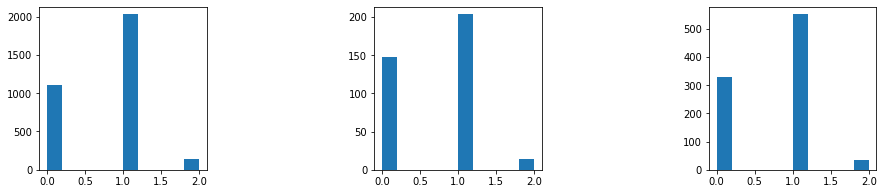

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

from sklearn.model_selection import train_test_split

train, test = train_test_split(ds, test_size=0.2, random_state=0, shuffle=True, stratify=None)
train, val = train_test_split(train, test_size=0.1, random_state=0, shuffle=True, stratify=None)

fig, ax = plt.subplots(1, 3, figsize=(15,3))
ax[0].hist(train['finding'])
ax[1].hist(val['finding'])
ax[2].hist(test['finding'])
fig.subplots_adjust(wspace=1.0)
plt.show()

## Exlpore the data

### Show Data Statistics
Plot a histogram of the data and explain your results

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc08bf25cd0>]],
      dtype=object)

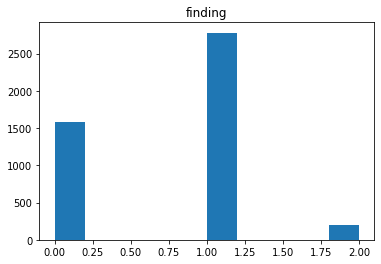

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

### Fill in your code
ds.hist(column='finding', grid=False)

it is visible that the data is imbalanced - there is very small amount of examples of finding 2 (covid), some of finding 0 (healthy) and most are 1 (BACTERIA).

### Explore the images
Show some example images from each catagory and explain biases or corruptions in the images.

explain how to avoid those biases and corruptions

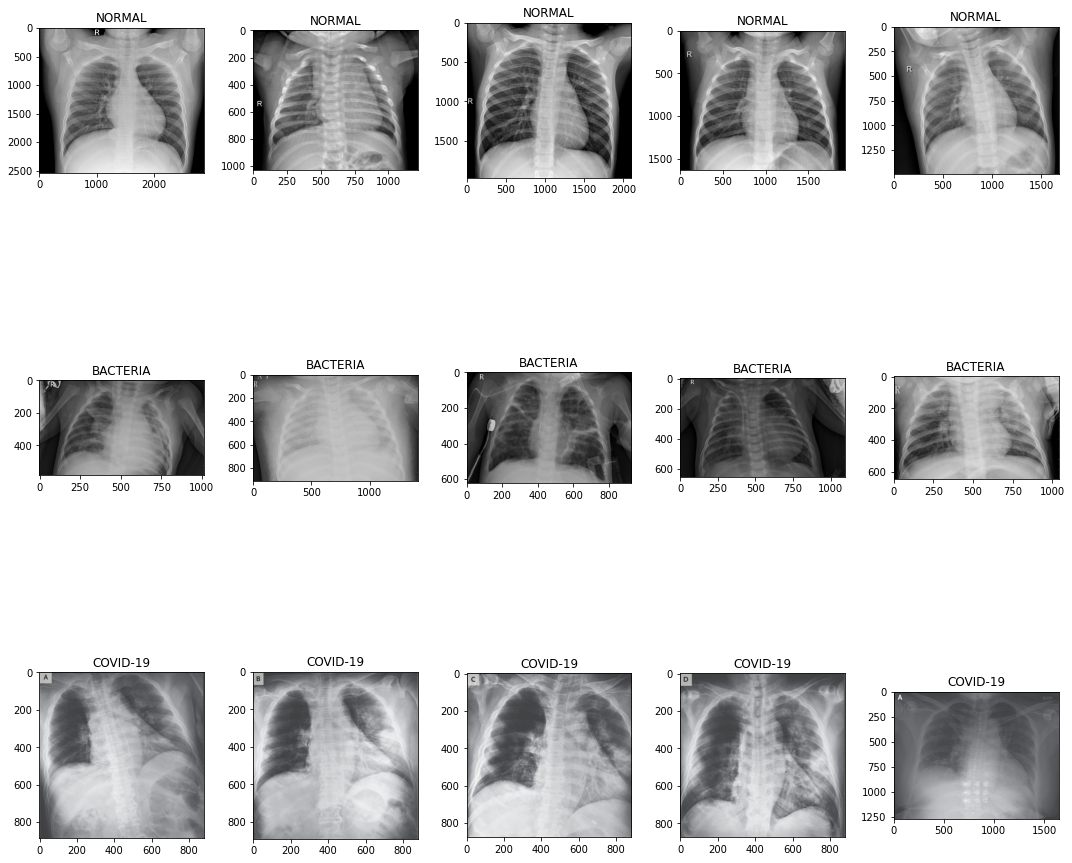

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

# make a figure & configure its parameters
findings = set(ds['finding'])
fig = plt.figure(1, figsize=(15,15))
rows, cols, i = len(findings), 5, 1

# display 3 examples from each label
for finding in findings:

    # go back to name from label
    name = label_to_finding[finding]
    if name == 'PNEUMONIA':
        name = "BACTERIA"
    elif "19" in name:
        name = "COVID-19"

    # filter for current type
    examples = ds[ds['finding'] == finding]

    # plot 3 cases
    for index, example in examples.head(cols).iterrows():
        image_path = Path(example['filepath'])
        plt.subplot(rows, cols, i, title=name)
        plt.imshow(plt.imread(image_path),cmap='gray')
        i += 1

fig.tight_layout()
plt.show()

**Fill your answers here:**
* covid-19 - zoomedm lungs are unclean, some are blurry
* there is variaty in position - not all are at the same angle
* contrast is not consistent
* there are letters in the sides/top corners so cropping can be affective
* we can add noise ourselves to mimic the noises that appear in the images

## Dealing with imbalanced data
There are many methods to try and overcome this problem, we will try 3 methods , all methods will be preformed solely on the train data:

*  **Under sampling:** Under-sampling balances the dataset by reducing the size of the abundant class. This method is used when quantity of data is sufficient. By keeping all samples in the rare class and randomly selecting an equal number of samples in the abundant class.

*  **Over sampling:** Over-sampling is used when the quantity of data is insufficient. It tries to balance dataset by increasing the size of rare samples. Rather than getting rid of abundant samples

* **Class weights:** Class weights tries to balance the data without changing the data itself. This can be achieved by giving different weights to both the majority and minority classes. The difference in weights will influence the classification of the classes during the training phase.







### Use the 3 diifferent methods in your training

Create an over sampled train set and a under sampled train set.

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

# use only in section 3.1, we will have 4 models : normal, over , under, class weights

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# oversampling = duplicate examples from the minority class
def over_sample(x, y):
    ros = RandomOverSampler(random_state=0)
    x_resampled, y_resampled = ros.fit_resample(x, y)
    return x_resampled, y_resampled

# undersampling = delete examples from the majority class
def under_sample(x, y):
    rus = RandomUnderSampler(random_state=0)
    x_resampled, y_resampled = rus.fit_resample(x, y)
    return x_resampled, y_resampled

# test functions :
x = ds['filepath'].values.reshape(-1, 1)
y = ds['finding'].values.reshape(-1, 1)

# sanity test over sampling:
x_over, y_over = over_sample(x, y)
print(type(x_over))
print(Counter(y_over))

# sanity test under sampling:
x_under, y_under = under_sample(x, y)
print(Counter(y_under))

<class 'numpy.ndarray'>
Counter({0: 2780, 1: 2780, 2: 2780})
Counter({0: 196, 1: 196, 2: 196})


create your class weights, explain your choise and how it affects your results

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

from sklearn.utils import class_weight

def class_weights(y_train):
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    weights = dict(zip(np.unique(ds['finding']), weights))
    return weights

# sanity test:
weights = class_weights(ds['finding'])
print(weights)

{0: 0.959991577174142, 1: 0.5466426858513189, 2: 7.753401360544218}


Since the loss is an averaged loss of all the samples, as shown in the picture below (for MSE loss)

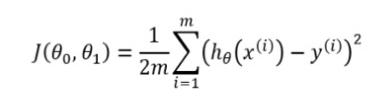

if we upsample a certain class we raise it's loss "weight" since more samples are computed through the loss. In the same manner if we downsample a certain class we decrease it's "weight" in the loss.

* For example, let's say we have an imbalance-dataset and class_j has only few images. If we upsample class_j images many times the average loss will improve class_j optimization since it is being aggregated to the loss many times. therfor the loss gradient will more likely to optimize class_j. from the same logic, if we down-sample a certain class_j, we decrease the class_j optimization while *loosing data as well!* since we're not using all the images of class_j.

Class-weight is more efficient way for changing the weights.
For example, in upsampling we duplicate the same data and running it thorugh the neural network over and over (wasting computation time)
In downsampling we omit data and therefor loose vital data.

Instead, We could just increase or decrease a certain class_i weight via a parameter weight_i directly via the loss function for each class.

To do so, we count how many images are from each class and create a weight vector.
Each item is instantiated via the following formula: \begin{equation} weight_i = \frac{k}{count(class_i)} \end{equation}
n is the samples amount and c is the classes amount: \begin{equation} k = \frac{n}{c}\end{equation}
Therefore, in case we have a certain class with less images, it’s weight will be higher, and therefore the it will be more considered in the loss and if certain class has a lot of images, each sample weight will be decrease accordingly.

## Create tf.Dataset
Create a tf.Dataset object from the train data, in which every entry has the label and the image.
Repeat for validation data.

Steps:
1.   Create a tf.dataset object from the dataframe. [1]
2.   Write a function that parse the data from each dataset entry to class/image [2]
3.   Apply the function on the dataset using tf.Dataset.map [2]

See:

[1] tf.dataset from pandas dataframe : https://www.tensorflow.org/tutorials/load_data/pandas_dataframe#load_data_using_tfdatadataset
[2] Image loading : https://www.tensorflow.org/tutorials/load_data/images#load_using_tfdata

**Step 1 - Create a tf.dataset object from the dataframe, each entry should contain filename and class.**

In [ ]:
def df_to_ds(xs, ys):
    xs = tf.convert_to_tensor(xs.values.tolist())
    ys = tf.convert_to_tensor(ys, dtype=tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((xs, ys))
    return ds

train_ds = df_to_ds(train['filepath'], train['finding'])
val_ds = df_to_ds(val['filepath'], val['finding'])
test_ds = df_to_ds(test['filepath'], test['finding'])

  Test your dataset object:

In [ ]:
for element in train_ds.take(5):
    filename, label = element[0], element[1]
    print ('Filename: {}, Label: {}'.format(filename, label))
    print(element)
    print()

Filename: b'/content/drive/Shareddrives/DNN_Ofek_Elad_Tomer/A2/chest_xray/train/PNEUMONIA/BACTERIA-9487238-0002.jpeg', Label: 1
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/Shareddrives/DNN_Ofek_Elad_Tomer/A2/chest_xray/train/PNEUMONIA/BACTERIA-9487238-0002.jpeg'>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)

Filename: b'/content/drive/Shareddrives/DNN_Ofek_Elad_Tomer/A2/chest_xray/train/PNEUMONIA/BACTERIA-5390159-0002.jpeg', Label: 1
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/Shareddrives/DNN_Ofek_Elad_Tomer/A2/chest_xray/train/PNEUMONIA/BACTERIA-5390159-0002.jpeg'>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)

Filename: b'/content/drive/Shareddrives/DNN_Ofek_Elad_Tomer/A2/chest_xray/train/PNEUMONIA/BACTERIA-9250380-0002.jpeg', Label: 1
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/Shareddrives/DNN_Ofek_Elad_Tomer/A2/chest_xray/train/PNEUMONIA/BACTERIA-9250380-0002.jpeg'>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)

Filename: b'/conten

* **Step 2 - Write a function to parse the image file name and return a grayscale image , resized to 512X512**.

> The mapping function will run each time a batch is fetched. the input is your dataset entry - (filepath,label) and the output should be (img,label).
\
Note that once the you read the image using tensorflow (tf.io.read_file), your operations should be on Tensors.

> You can use a mapping function to tranform the data randomly each time a batch is fetched for data augmentation.
https://www.tensorflow.org/tutorials/images/data_augmentation


In [ ]:
import pathlib

# adds a dimension and resize to smaller images - RAM limitations
def decode_img(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, size=[128, 128])
    return image

# Gray-scale mapper, return image,label
def map_function(filename, label):
    image = tf.io.read_file(filename.numpy())
    filename, file_extension = os.path.splitext(filename.numpy())
    file_extension = file_extension[1:].decode("utf-8")
    if file_extension in ['jpg', 'JPG', 'jpeg']:
        image = tf.image.decode_jpeg(image, channels=1)
    elif file_extension in ['png']:
        image = tf.image.decode_png(image, channels=1)
    else:
        print("ERROR! " + file_extension)
        exit(1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = decode_img(image)
    return image, label

# RGB mapper, return image,label
def rgb_map_function(filename, label):
    image = tf.io.read_file(filename.numpy())
    filename, file_extension = os.path.splitext(filename.numpy())
    file_extension = file_extension[1:].decode("utf-8")
    if file_extension in ['jpg', 'JPG', 'jpeg']:
        image = tf.image.decode_jpeg(image, channels=3)
    elif file_extension in ['png']:
        image = tf.image.decode_png(image, channels=3)
    else:
        print("ERROR! " + file_extension)
        exit(1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = decode_img(image)
    return image, label

(128, 128, 1)
(128, 128, 1)
(128, 128, 1)


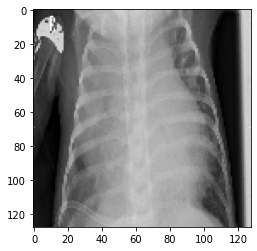

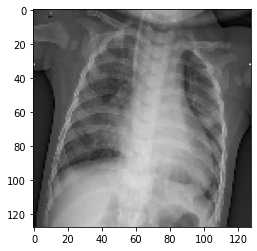

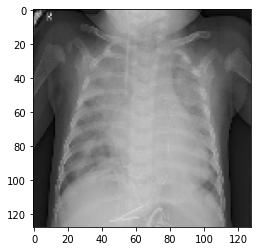

In [ ]:
# test
for img_path, lbl in train_ds.take(3):
    image, label = map_function(img_path, lbl)
    print(image.shape)
    plt.figure()
    plt.imshow(image.numpy().squeeze(), cmap='gray')

* Step 3 - Apply the mapping function on the dataset

In [ ]:
train_ds_map =  train_ds.map(lambda x,y: tf.py_function(map_function, [x,y], [tf.float32, tf.int32]))
val_ds_map =  val_ds.map(lambda x,y: tf.py_function(map_function, [x,y], [tf.float32, tf.int32]))
test_ds_map =  test_ds.map(lambda x,y: tf.py_function(map_function, [x,y], [tf.float32, tf.int32]))

Test your dataset:

(128, 128, 1)
()
(128, 128, 1)
()


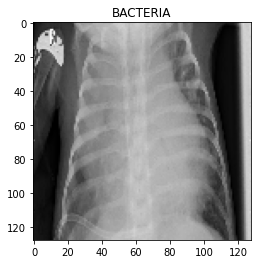

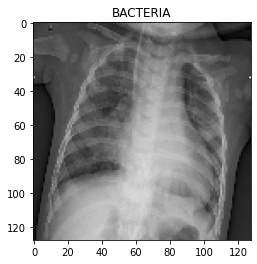

In [ ]:
for image, label in train_ds_map.take(2):
    plt.figure()
    plt.imshow(image.numpy().squeeze(),cmap='gray')
    plt.title(label_to_finding[label.numpy()])
    print(image.shape)
    print(label.shape)

plt.show()

# 2. Data Augmentation

Now, we want to add data augmentation to the training set.



\
Write a function that operates on entries of your dataset, and augments them, and then apply this function to your dataset.

You can use functions from tf.image.random_* to randomly augment your data as you process it.
For example, to randomly flip your image:

```
  img = tf.image.random_flip_left_right(img)
```



In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

#augmentations
gauss_noise = tf.keras.layers.GaussianNoise(0.1)
random_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")
contrast    = tf.keras.layers.RandomContrast(factor=(0,1))
zoom        = tf.keras.layers.RandomZoom(1)
rotation    = tf.keras.layers.RandomRotation(0.1, fill_mode='reflect', interpolation='bilinear', seed=None, fill_value=0.0)

augmentations = [None, gauss_noise, random_flip, contrast, zoom, rotation]
aug_names = ['None', 'gauss_noise', 'random_flip', 'contrast', 'zoom', 'rotation']
augs = zip(augmentations, aug_names)

def choose_augmentation(aug):
    def augment(data, label):
        if aug == None:
            return data, [label]
        augment = tf.keras.Sequential(aug)
        augmented = augment(data, training=True)
        return augmented, [label]
    return augment

We will test your data augmentation before coosing the model
\
We will process the same entry several times and should see different results.

# Prepare datasets for training
So far we defined datasets that can be used for training, but are not yet ready to process large amounts of data fast.

\\
We would like to make our dataset ready for fast batch processing.
The following function does that:
*   Cache your data - load it to your RAM/save it to file for faster access.
*   Shuffle your data.
*   Repeat the data - makes the iterator cyclic, so it will be repeated after each epoch, making an "infinite" dataset. This may be ommited, but the training process may differ.
*   Batch the data - fetch the data in batches, each batch has batch_size entries.
*   Prefetch the data - while you process one batch, the CPU will prefetch the next batches (including preprocessing and augmentations)


for further reading - https://www.tensorflow.org/guide/data


In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

#Source https://www.tensorflow.org/tutorials/load_data/images#load_using_tfdata

def prepare_for_training(x, y, aug, batch_size, cache=True, shuffle_buffer_size=1000, rgb_mode=False):

    map_func, input_shape = (rgb_map_function, (128,128,3)) if rgb_mode else (map_function, (128,128,1))
    # convert from dataframe to dataset
    ds = df_to_ds(x, y)

    # map paths to images
    ds = ds.map(lambda x,y: tf.py_function(map_func, [x, y], [tf.float32, tf.int32]))

    # apply augmentation
    ds = ds.map(lambda x,y: tf.py_function(aug, [x, y], [tf.float32, tf.int64]))

    # reshape
    ds = ds.map(lambda x,y: (tf.reshape(x, input_shape), tf.reshape(y, ([]))))

    # if cache:
    #     if isinstance(cache, str):
    #         ds = ds.cache(cache)
    #     else:
    #         ds = ds.cache()

    # shuffle batch & prefetch
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


# 5. Evaluation methods
we wrote functions to easily implement both the tensorboard and the tsne into our training.


In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

from tensorboard.plugins import projector
import tensorflow_datasets as tfds
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

class_names =  ["Normal", "Bacteria", "Covid-19"]
cwd = os.getcwd()

# create new log file for each training session
def new_log(name):
    # log_dir = "/content/logs/" + name
    log_dir = cwd + "/logs/" + name
    callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=False,write_images=False)
    return callback

def get_data_from_tfds(tfds):
  return tfds.map(lambda x,y: x)

def get_labels_from_tfds(tfds):
  return tfds.map(lambda x,y: y)

# use tsne
def tsne(model, model_name, test_labels, test_images, class_names):

    # create model dir for t-SNE logs with all labels
    log_dir = cwd + '/logs/covid_' + model_name + '/'
    # log_dir = 'logs/covid_' + model_name + '/'
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    # create metadata = labels
    with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
        for row in test_labels:
            f.write("{}\n".format(class_names[int(row.numpy())]))

    # get model output & congif
    test_pred = model.predict(test_images)
    features = tf.Variable(test_pred, name='features')
    checkpoint = tf.train.Checkpoint(embedding=features)
    checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()

    #The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
    embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = "metadata.tsv"

    projector.visualize_embeddings(log_dir, config)

# evaluate model
def evaluate_model(model, test_filepath, test_labels, class_names, model_name=None, rgb_mode=False):

    test_ds = prepare_for_training(test_filepath, test_labels, aug=no_aug, batch_size=1,rgb_mode=rgb_mode)
    x_test = get_data_from_tfds(test_ds)
    y_test = get_labels_from_tfds(test_ds)
    # overall accuracy
    test_loss, test_acc = model.evaluate(test_ds, verbose=2)
    print('\nTest accuracy:', test_acc)

    # convert to probabilities
    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    pred_y_test = probability_model.predict(x_test)
    pred_y_test = np.argmax(pred_y_test, axis=1)

    # per class accuracy
    print(classification_report(test_labels, pred_y_test, target_names=class_names))

    # confusion matrix
    print(confusion_matrix(test_labels, pred_y_test))

# Balancing

here are methods for balancing

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

from sklearn.model_selection import train_test_split

INPUT_IMAGE_SHAPE = (128, 128, 1)
BATCH_SIZE = 8

# define small temporary model just to sanity check augmentations & data balancing
def run_temp_model(tr, vl, weights):

    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(128, 128, 1), dtype=tf.float32),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3)
    ])

    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.fit(tr, epochs=5, validation_data=vl, class_weight=weights)
    return model

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

def balance(x, y, b_type):

    'balance 0 = None, 1 = over, 2 = under, 3 = weights'

    if b_type == 0:
        return x, y, None

    elif b_type == 1:
        x, y = over_sample(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
        return x, y, None

    elif b_type == 2:
        x, y = under_sample(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
        return x, y, None

    elif b_type == 3:
        w = class_weights(y)
        return x, y, w

    else:
        print("None of the balancing method fits your choice")
        exit(1)

 # 1.3 Test balancing

**try a small example of normal vs over vs under vs class weights :**



### prepare validation & test ds for this tests

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

no_aug = choose_augmentation(None)
val_ds  = prepare_for_training(val['filepath'], val['finding'], no_aug, BATCH_SIZE)

### test no balancing

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

x_train, y_train, weights = balance(train['filepath'], train['finding'], 0)
aug = choose_augmentation(None)
train_ds = prepare_for_training(x_train, y_train, no_aug, BATCH_SIZE)

model = run_temp_model(train_ds, val_ds, weights)
evaluate_model(model, test['filepath'], test['finding'], class_names)

Epoch 1/5


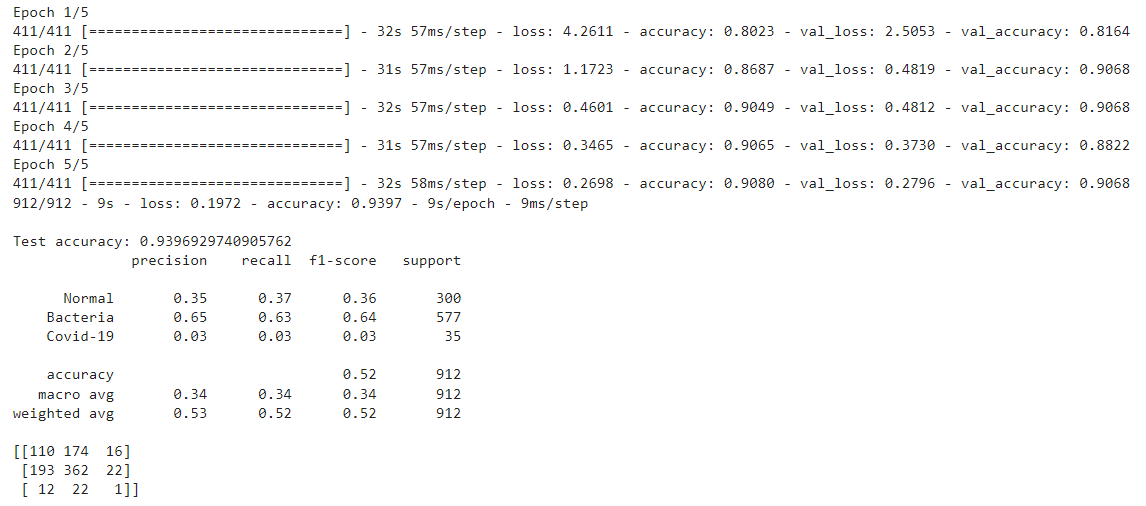

we can see a problem with covid classification

### test over sampling

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

x_train, y_train, weights = balance(train['filepath'], train['finding'], 1)
df = pd.DataFrame({'filepath': x_train.squeeze(), 'finding': y_train.squeeze()})
train_ds = prepare_for_training(df['filepath'], df['finding'], no_aug, BATCH_SIZE)

model = run_temp_model(train_ds, val_ds, weights)
evaluate_model(model, test['filepath'], test['finding'], class_names)

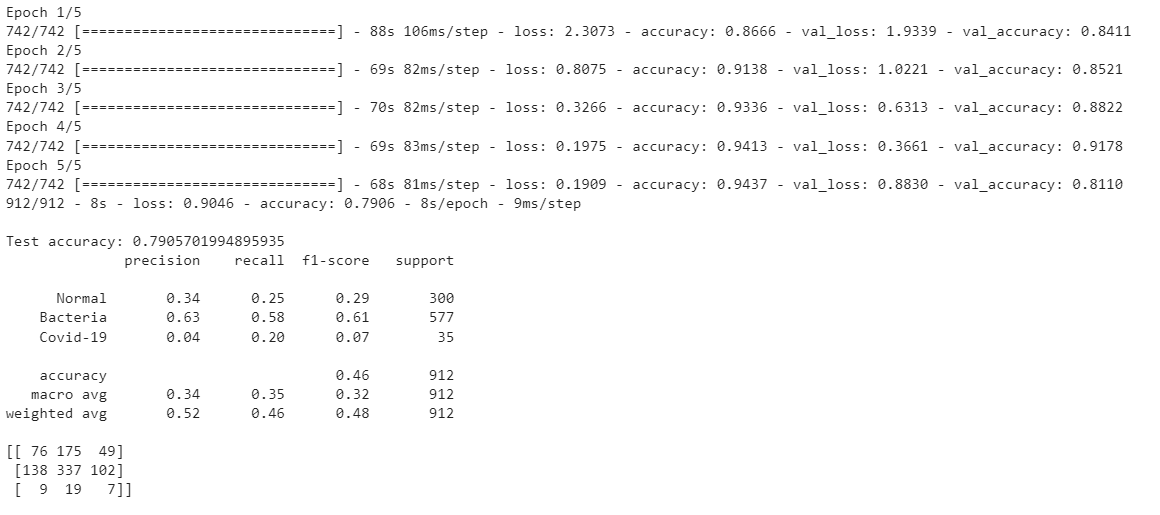

### test under sampling

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

x_train, y_train, weights = balance(train['filepath'], train['finding'], 2)
df = pd.DataFrame({'filepath': x_train.squeeze(), 'finding': y_train.squeeze()})
train_ds = prepare_for_training(df['filepath'], df['finding'], no_aug, BATCH_SIZE)

model = run_temp_model(train_ds, val_ds, weights)
evaluate_model(model, test['filepath'], test['finding'], class_names)

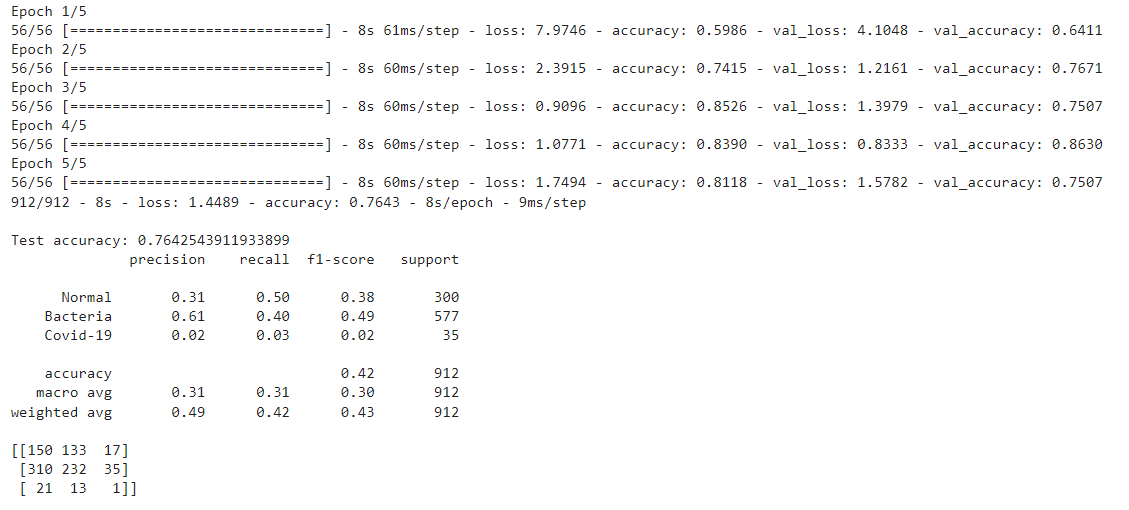

### test class weights

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

x_train, y_train, weights = balance(train['filepath'], train['finding'], 3)
train_ds = prepare_for_training(x_train, y_train, no_aug, BATCH_SIZE)

model = run_temp_model(train_ds, val_ds, weights)
evaluate_model(model, test['filepath'], test['finding'], class_names)

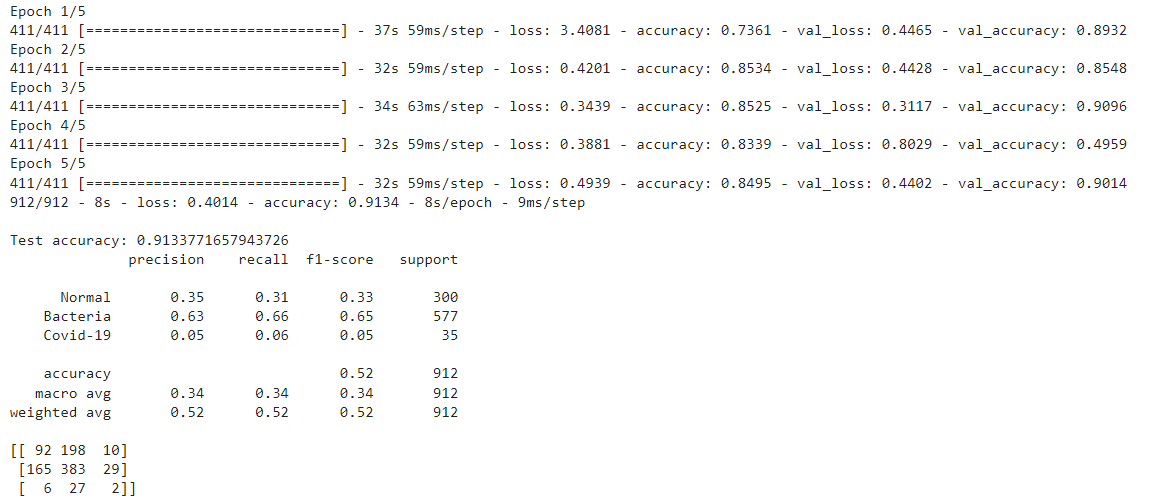

### results

it seems that class weights somewhat improves performance on covid class, so that is what we will use

 # 2. Test augmentation

### prepare validation ds

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)
no_aug = choose_augmentation(None)
curr_val = prepare_for_training(val['filepath'], val['finding'], aug=no_aug, batch_size=8)


### test no augmentation

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

aug = choose_augmentation(None)
curr_train = prepare_for_training(train['filepath'], train['finding'], aug=aug, batch_size=8)

run_temp_model(curr_train, curr_val, weights=None)

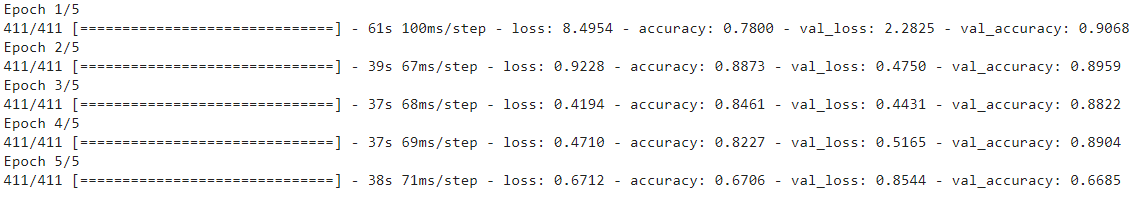

### test gaussian noise

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

aug = choose_augmentation([gauss_noise])
curr_train = prepare_for_training(train['filepath'], train['finding'], aug=aug, batch_size=8)

run_temp_model(curr_train, curr_val, weights=None)

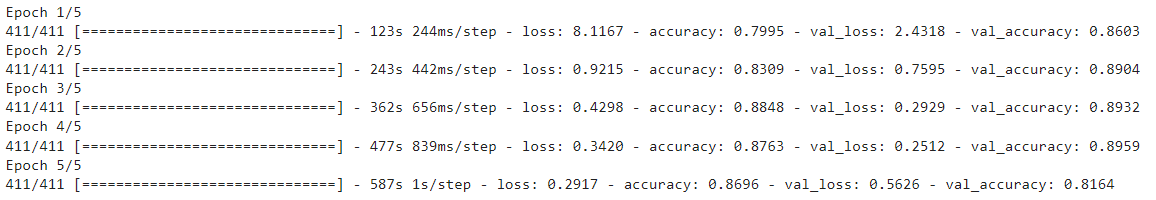

### test random flip

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

aug = choose_augmentation([random_flip])
curr_train = prepare_for_training(train['filepath'], train['finding'], aug=aug, batch_size=8)

run_temp_model(curr_train, curr_val, weights=None)

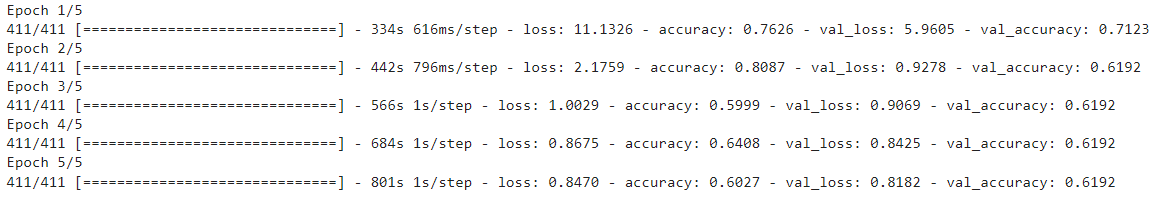

### test contrast

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

aug = choose_augmentation([contrast])
curr_train = prepare_for_training(train['filepath'], train['finding'], aug=aug, batch_size=8)

run_temp_model(curr_train, curr_val, weights=None)

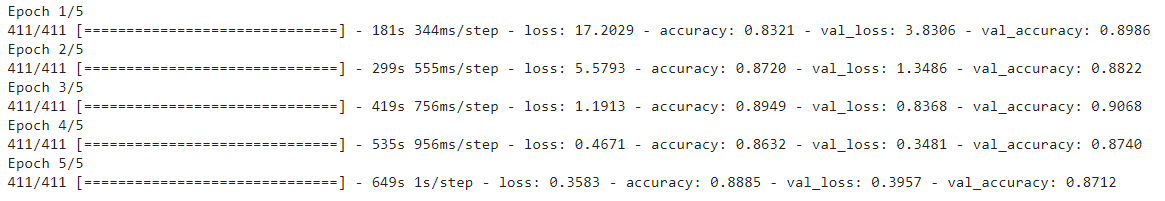

### test zoom

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

aug = choose_augmentation([zoom])
curr_train = prepare_for_training(train['filepath'], train['finding'], aug=aug, batch_size=8)

run_temp_model(curr_train, curr_val, weights=None)

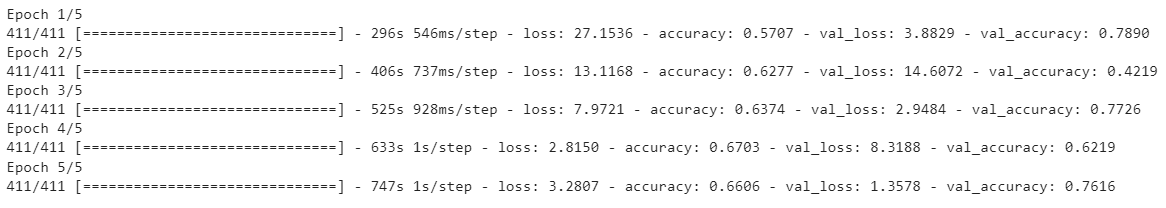

### test rotation

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

aug = choose_augmentation([rotation])
curr_train = prepare_for_training(train['filepath'], train['finding'], aug=aug, batch_size=8)

run_temp_model(curr_train, curr_val, weights=None)

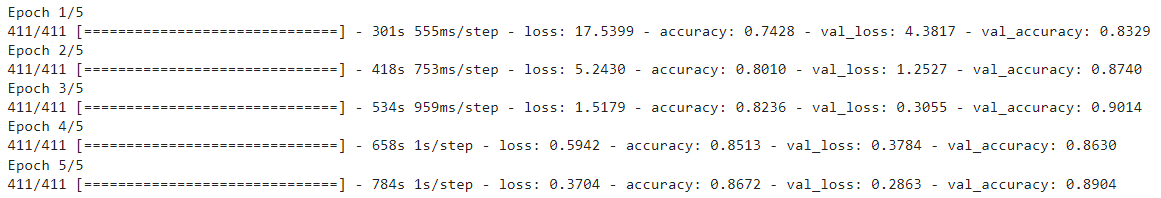

### results


the augmentations that seems to have a positive affect in our mini-testing are **gauss_noise & contrast & rotation**, so we will use those.

after inspecting the images in a previous task, we think it makes sense that these are the augmentations that helped - we saw contrast variability & noisy images, as well as different chest positions.

# 3. Choosing a Model

## final - prepared & augment the data

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

BATCH_SIZE = 8

# take chosen augmentation methods - gauss_noise, contrast & rotation
aug = choose_augmentation([gauss_noise, contrast, rotation])
no_aug = choose_augmentation(None)

# take chosen balancing method - class weights
x_train, y_train, train_weights = balance(train['filepath'], train['finding'], 3)

# prepare datasets for training & testing
ready_train = prepare_for_training(x_train, y_train, aug, BATCH_SIZE)
ready_val   = prepare_for_training(val['filepath'], val['finding'], no_aug, BATCH_SIZE)
ready_test  = prepare_for_training(test['filepath'], test['finding'], no_aug, batch_size=1)

## 3.1 Train a classification network

Now that you have a dataset ready, you are steps away from training your own classification network to help detect COVID-19 cases!


*   Build your CNN classification model and fit it.
*   Add data augmentations




### define the model

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

# architectures options:
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0265949
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0262052#sec003
# https://www.hindawi.com/journals/complexity/2021/6621607/
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8081579/

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

def cnn_3_1():
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.2),
        Dense(128),
        Dense(3)
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

### run the model

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

# clear all logs from previous runs
# % rm -rf ./logs/

# create logs dir if not there
log_dir = cwd + '/logs/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# configure final model
batch_size = 32
model_name = "cnn_3_1"
c_path = log_dir + "cnn_3_1.hdf5"

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

from keras.callbacks import ModelCheckpoint

# get the model
model = cnn_3_1()

# reload model weights for rerun due to colab being insufferable
model.load_weights(c_path)
checkpoint = ModelCheckpoint(c_path, monitor='val_loss', verbose=1)
model.fit(ready_train, batch_size=batch_size, epochs=1, validation_data=(ready_val), class_weight=train_weights, callbacks=[new_log(model_name), checkpoint])

411/411 [==============================] - ETA: 0s - loss: 0.3672 - accuracy: 0.8416 
Epoch 1: saving model to /content/drive/Shareddrives/DNN_Ofek_Elad_Tomer/A2/logs/cnn_3_1.hdf5
411/411 [==============================] - 3091s 6s/step - loss: 0.3672 - accuracy: 0.8416 - val_loss: 0.4826 - val_accuracy: 0.8438


In [ ]:
model.fit(ready_train, batch_size=batch_size, epochs=5, validation_data=(ready_val), class_weight=train_weights, callbacks=[new_log(model_name), checkpoint])

### evaluate results

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

#Plot your training process. valid/train loss. are you over/under fitted?

test_im = get_data_from_tfds(ready_test)
test_labels = get_labels_from_tfds(ready_test)

# evaluate_model(model, test['filepath'],test['finding'], class_names, model_name)
model = cnn_3_1()
model.load_weights(c_path)

In [ ]:
evaluate_model(model, test['filepath'], test['finding'], class_names, model_name)

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

tsne(model, model_name, test_labels, test_im, class_names)

%reload_ext tensorboard
%tensorboard --logdir logs/covid_cnn_3_1/

# %reload_ext tensorboard
# %tensorboard --logdir logs/covid_cnn_3_1/

**•	Are you overfitted? Why? What can you do?**

There is noticeable overfitting accruing during the training. There are a lot of ways to deal with this. We could add more dropout, strengthen or change the augmentation add a regularization factor and probably many more methods. One possible reason we have overfitted is the use of class weights which might have caused the model to memorize the covid cases instead of learning to recognize them. A bigger and more balanced dataset would have obviously helped in this case

**•	Can the classes be distinguished?**

The Bacteria and Normal classes reach a high accuracy but the covid-19 does not. This is likely related to the imbalanced dataset which we already mentioned. If we trained the model for longer it is very feasible that the model would have produced better results on the covid-19 cases but we are at the limits of what we can get from google colab and limited to those shorter training session.

**•	What are the data limits? Can we filter/process it better?**

We could add more refined augmentation to the data. The augmentation in this case could be a crucial part in combatting the lower covid-19 accuracy since we may get more varied results from the covid-19 images( only if we use oversampling balancing of course).

**•	Is it possible that we are classifying the X-Ray machine and not the case?**

The images are coming from varied sources there is a chance that one of the sources has more or even only covid-19 cases or only bacteria cases. In that case the answer is yes, the model could learn to predict from which x-ray machine the image came from.



**•**
since we have limited resources (issues with using GPU in colab & RAM limitations), we believe that if we could build a heavier model and train for longer we will achieve better results.

## 3.2 Transfer learning

transfer learning (https://www.tensorflow.org/tutorials/images/transfer_learning)

Load the pre trained ResNet-50 model and fine tune it to your data. (https://www.tensorflow.org/api_docs/python/tf/keras/applications)



In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

# Since ImageNet weights are designated for RGB input, we are loading the pictures via rgb_mode=True
batch_size = 32
rgb_train_ds = prepare_for_training(train['filepath'], train['finding'], aug, batch_size, rgb_mode=True)
rgb_val_ds   = prepare_for_training(val['filepath'], val['finding'], no_aug, batch_size, rgb_mode=True)


In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

### load ResNet-50 with include_top=False:

# RGB Input
input_shape=(128,128,3)

resnet50_pretrained = tf.keras.applications.resnet50.ResNet50(
include_top=False,
weights='imagenet', # Weights initialized for Imagenet database
input_tensor=None,
input_shape=input_shape)

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

### prepare it for training- freeze the resnet layers and add a classification head

# Fixing the Resnet50 Layers in order to use them as feature extraction
for layer in resnet50_pretrained.layers:
    layer.trainable=False


tf_model = tf.keras.Sequential([
                                # Pretrained model
                                resnet50_pretrained,
                                # Classification head
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(512, activation='relu'),
                                tf.keras.layers.Dense(256, activation='relu'),
                                tf.keras.layers.Dense(3)])

# From logits is True to append a softmax layer
tf_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

###Resnet50
We used Resnet50 Transfer Learning model with 3 trainable layers for adapting our classification problem while fixing the feature extracting layers.

As shown in the summary below there are 268,572,163 trainable parameters while the other 23,577,344 parameters are fixed and as such are non-trainable

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

tf_model.summary()

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

### train the model:
tf_model.fit(rgb_train_ds, batch_size=batch_size, epochs=5, validation_data=(rgb_val_ds))
#tf_model.load_weights(r"/content/sample_data/resnet50_epoch_1.h5")
tf_model.save_weights('resnet50_epoch_1.h5')

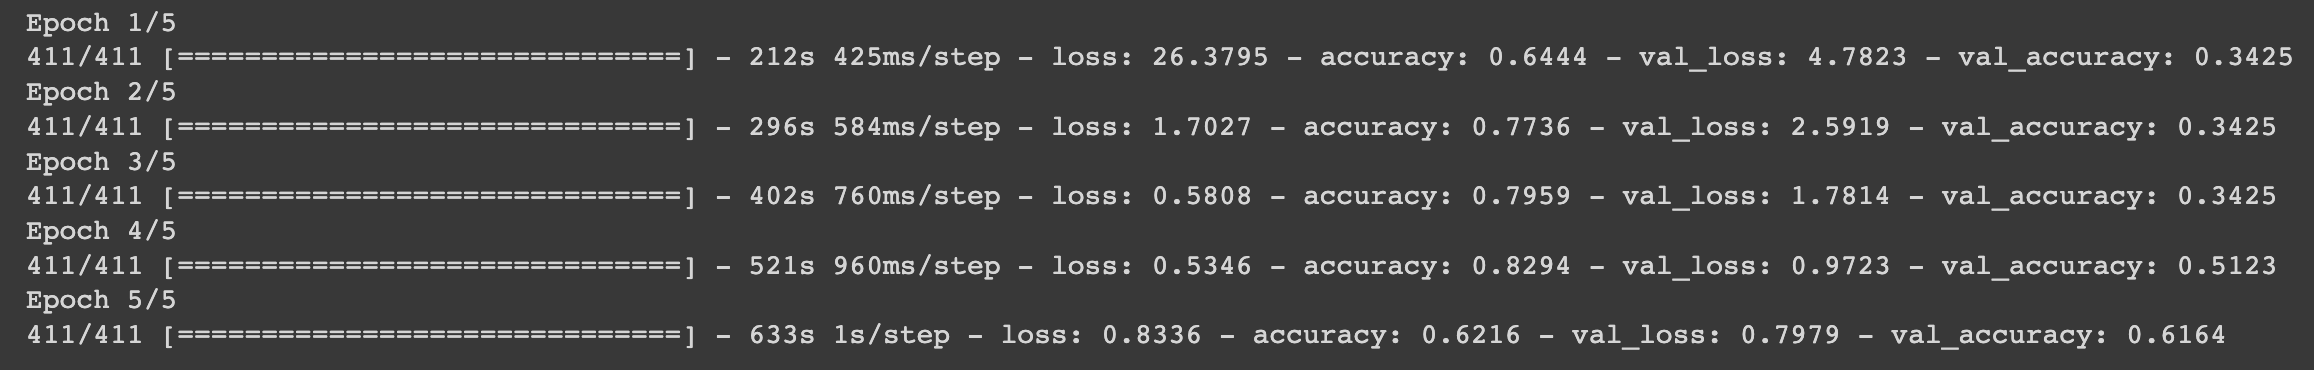

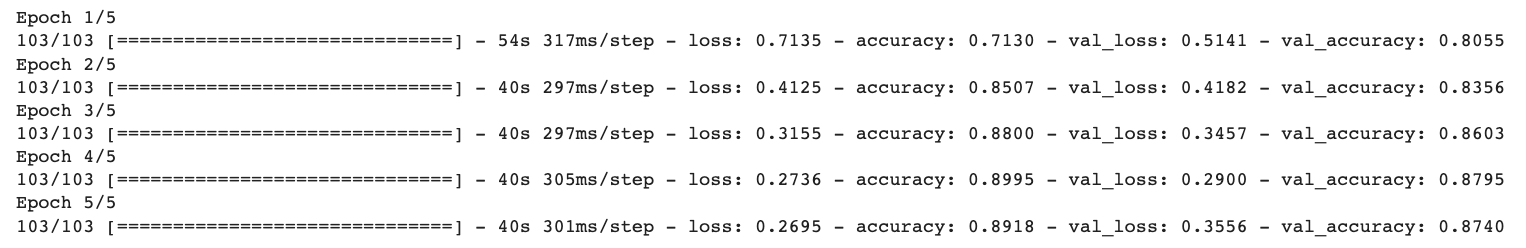

Evaluate your results and compare them to your own CNN model.


We evaluated a Resnet50 model which was pretrained upon the ImageNet database. As shown below, imagenet **do not contain x-ray images nor contain gray-scale images from any kind**. Since the resnet-50 scored only 61% accuracy, Our assumption is that these weights aren't suitable for detecting and differentiating between lung viruses such as COVID-19/BACTERIA or a NORAML condition upon **grayscale X-ray images**.
* We managed to raise the validation accuracy to 85% via changing the network hyper parameters and adding average pooling

As shown upwards, the Vanilla CNN scored much better accuracy results since it was trained entirely and therfor was designated to extract the relevant features for lung viruses classification unlike the Resnet50 model which most of its weights is designated for feature extraction upon Imagenet database. (since we fixed the Resnet50 layers)

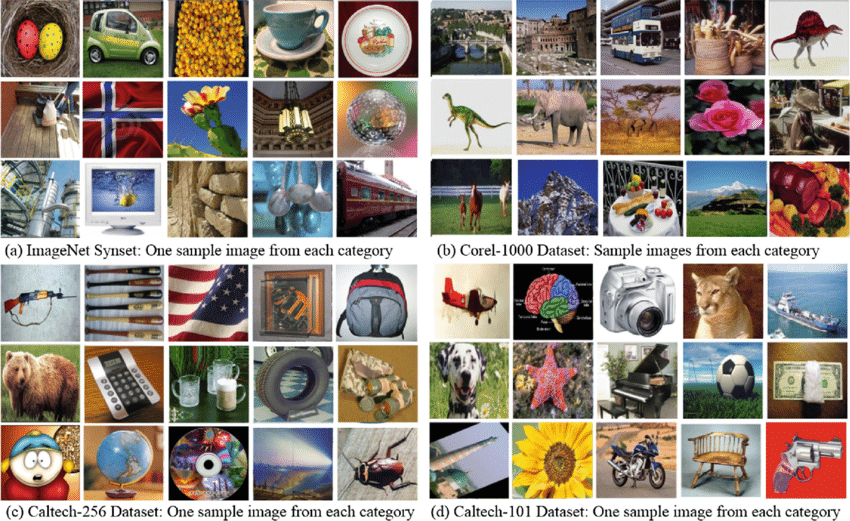

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)
model_name = "tl_imagenet"

#Plot your training process. valid/train loss. are you over/under fitted?
rgb_test_ds  = prepare_for_training(test['filepath'], test['finding'], no_aug, batch_size=1, rgb_mode=True)

test_im = get_data_from_tfds(rgb_test_ds)
test_labels = get_labels_from_tfds(rgb_test_ds)

evaluate_model(tf_model, test['filepath'],test['finding'], class_names, model_name,rgb_mode=True)

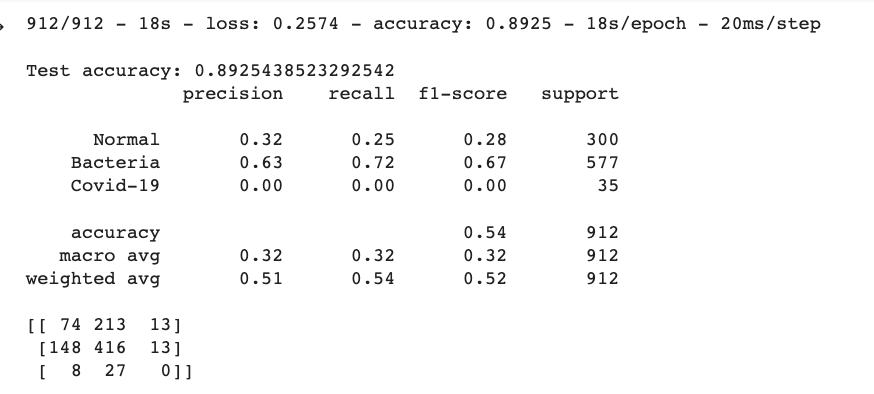

In [ ]:
tsne(tf_model, model_name, test_labels, test_im, class_names)

%load_ext tensorboard
%tensorboard --logdir logs/covid_tl_imagenet/

In [ ]:
%tensorboard --logdir logs/covid_tl_imagenet/

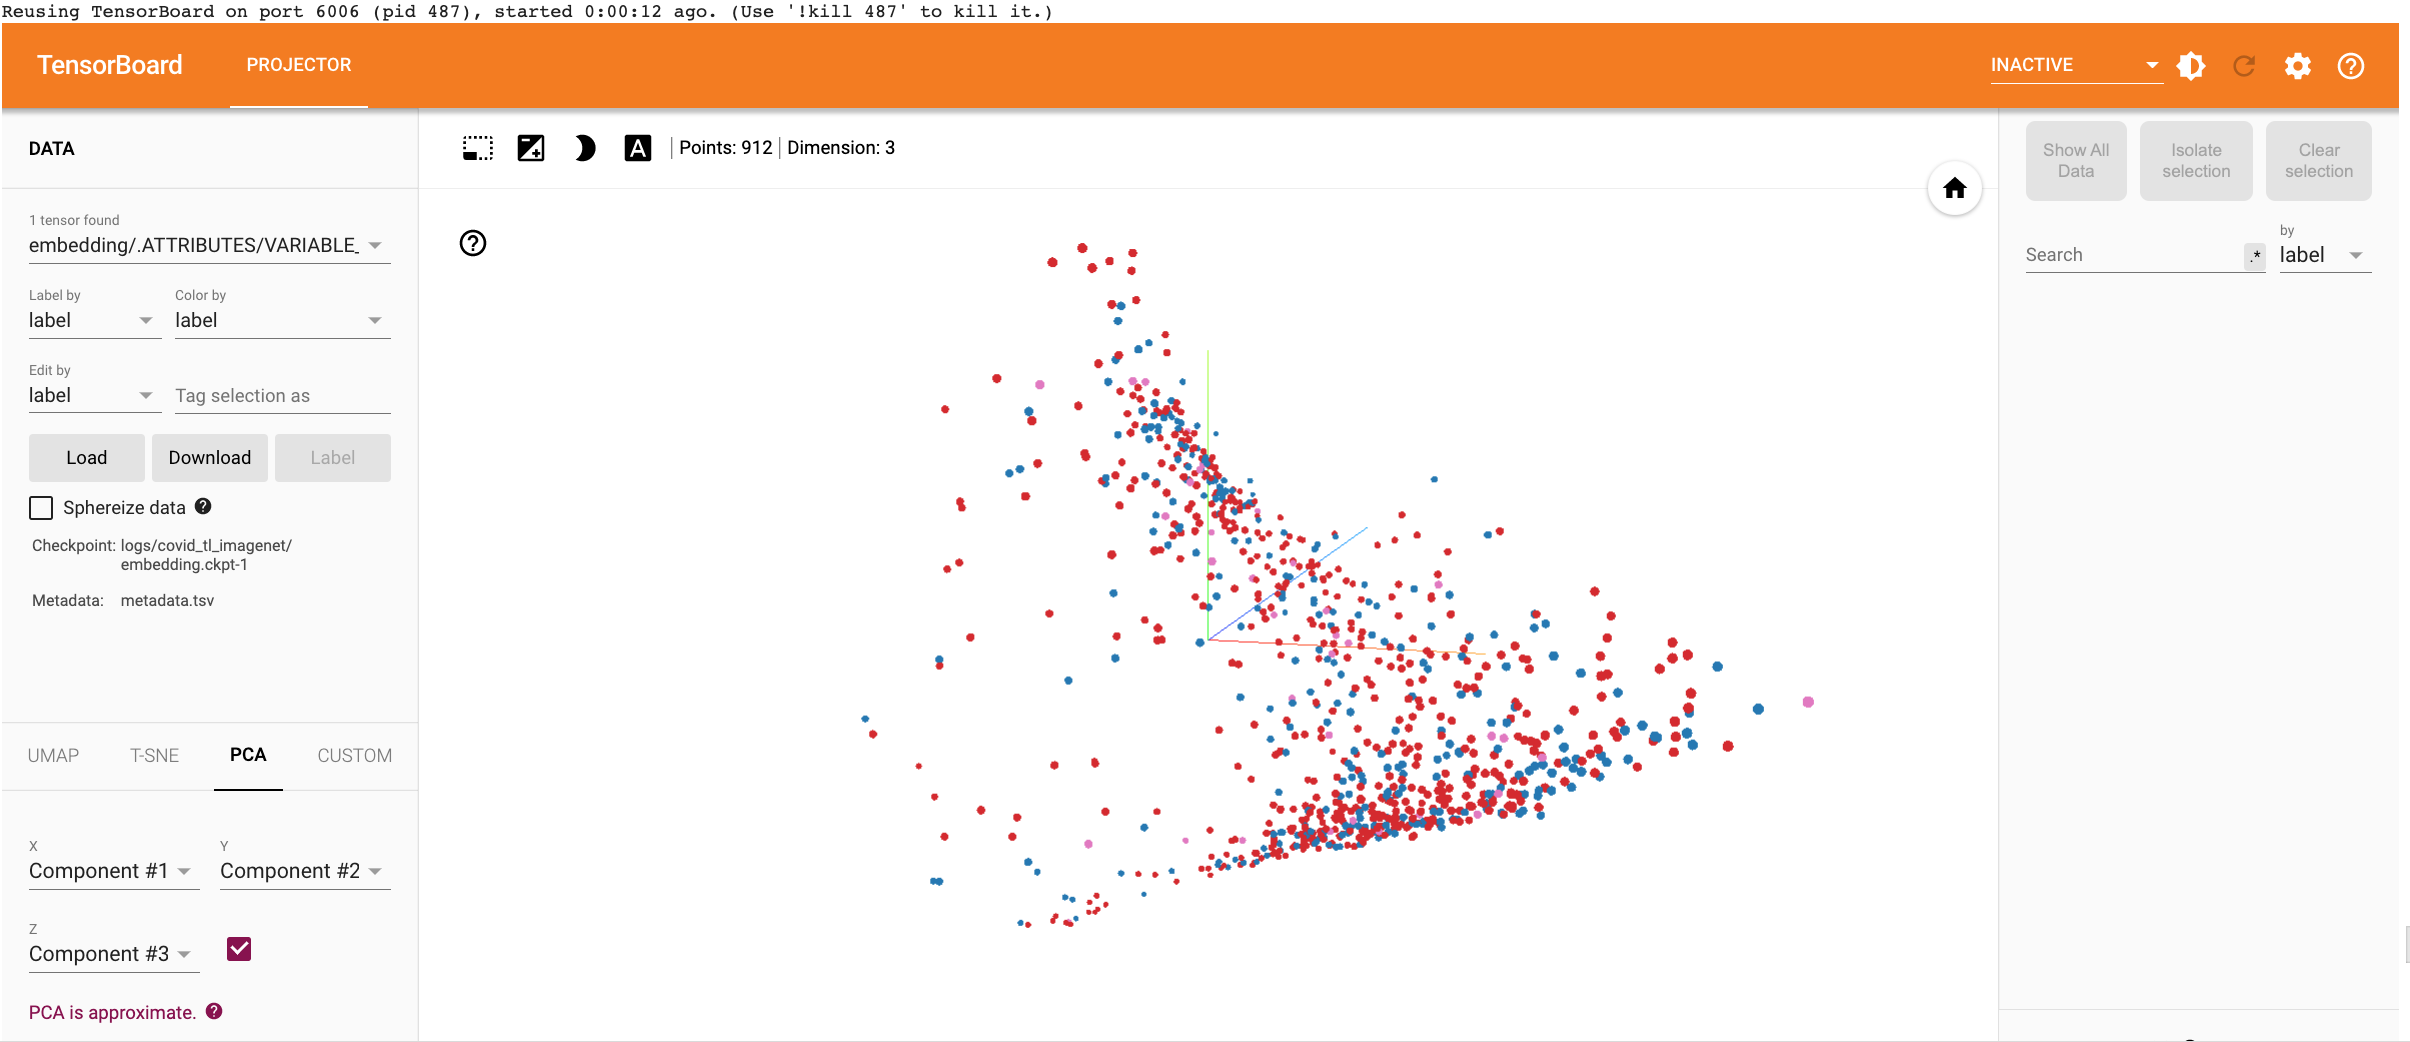

For our suprise, evaluated Resnet50 model with random weights initialization. As shown in the results, even random initialization scored much better success than imagenet weights which was trained to detect greatly different data. this is directly supporting our theory, and explaining that the imagenet fixed weights detriorate the model's performance.

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

### load ResNet-50 with include_top=False:

resnet50_pretrained_random_weights = tf.keras.applications.resnet50.ResNet50(
include_top=False,
weights=None, # Random weights initialization
input_tensor=None,
input_shape=(512,512,1)) # Here we are not obligated to 3 channels like in the previous example

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

### prepare it for training- freeze the resnet layers and add a classification head

# Fixing the Resnet50 Layers in order to use them as feature extraction
for layer in resnet50_pretrained_random_weights.layers:
    layer.trainable=False


tf_model_random_weights = tf.keras.Sequential([
                                # Pretrained model
                                resnet50_pretrained_random_weights,
                                # Classification head
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(512, activation='relu'),
                                tf.keras.layers.Dense(256, activation='relu'),
                                tf.keras.layers.Dense(3)])

# From logits is True to append a softmax layer
tf_model_random_weights.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

### train the model:

tf_model_random_weights.fit(train_ds, batch_size=batch_size, epochs=5, validation_data=(val_ds))
tf_model_random_weights.save_weights('resnet50_epoch_random_1.h5')

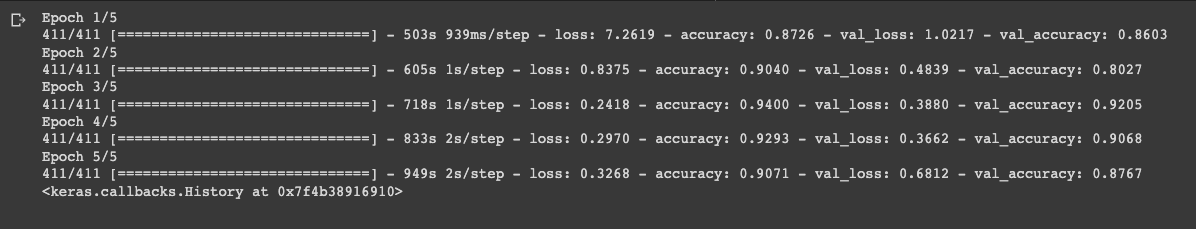

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

tf_model_random_weights.evaluate(rgb_test_ds)

# 4. Test Time Augmentation

Similar to what Data Augmentation is doing to the training set, the purpose of Test Time Augmentation is to perform random modifications to the test images. Thus, instead of showing the regular, “clean” images, only once to the trained model, we will show it the augmented images several times. We will then average the predictions of each corresponding image and take that as our final guess.

## Use Test Time Augmentation
Using your choise of augmentations write your own code for test time augmentation

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

# configure augmentations
gaus = choose_augmentation([gauss_noise, contrast, rotation])
cont = choose_augmentation([gauss_noise, contrast, rotation])
rot = choose_augmentation([gauss_noise, contrast, rotation])
augs = [gaus, cont, rot]

# get the trained model
model = cnn_3_1()
model.load_weights(c_path)

predictions = []
for aug in augs:
    test_ds  = prepare_for_training(test['filepath'], test['finding'], aug, 1)
    x_test = get_data_from_tfds(test_ds)
    y_test = get_labels_from_tfds(test_ds)
    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    pred_y_test = probability_model.predict(x_test)
    pred_y_test = np.argmax(pred_y_test, axis=1)
    predictions.append(pred_y_test)

pred = np.mean(predictions, axis=0)
np.mean(np.equal(np.argmax(y_test, axis=-1), np.argmax(pred, axis=-1)))

0.0

## Compare your test results with those of the previous sections   

In [ ]:
# Elad Sofer (312124662), Tomer Shaked (315822221), Ofek Finkelstein (316406792)

### Fill in your code